In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
import scipy.stats as stats

In [ ]:
import xgboost as xgb

In [2]:
X=pd.read_csv('x_train.csv',delimiter=";",header=None,names=['f'+str(i) for i in range (223)])
y=pd.read_csv('y_train.csv',names=['class'])
y=y['class']
X_test=pd.read_csv('x_test.csv',delimiter=";",header=None,names=['f'+str(i) for i in range (223)])

# Baseline

In [3]:
rf=RandomForestClassifier(max_features='auto',n_estimators=300,max_depth=100,random_state=42)
print (np.mean(cross_val_score(rf, X, y, cv=5)))

0.557454376621


# Отбор фич
Пусть $X$ - некий набор признаков
1. Считаем Взаимную информацию между признаками и целевой переменной.
Удаляем из $X$ все признаки $f_i$, у которых ВИ меньше ПорогаИнформации
Получаем набор признаков $X_1$
2. Далее удаляем из $X_1$ признаки $f_i$, если найдется такой признак $f_j$, что корреляция между ними больше  больше ПорогаКорреляции, а ВИ у $f_j$ больше

In [4]:
def make_selection(X,mi_threshold,corr_threshold):
    X_sel=X.copy()
    # Считаем взаимную информацию
    mi=mutual_info_classif(X_sel,y,n_neighbors=5,random_state=42)
    # Удаляем признаки с ВИ меньше порога
    X_sel.drop(X_sel.columns[mi<mi_threshold],axis=1,inplace=True)
    print ("ftr qty after remove on MI: "+str(X_sel.shape[1]))
    # Формируем список признаков в порядке убывания ВИ
    cols=pd.Series(data=mi,index=X.columns).sort_values(ascending=False).index
    # Обходим признаки
    for ftr1 in cols:
        for ftr2 in cols: 
            if (ftr1==ftr2)|(not(ftr1 in list(X_sel.columns)))|(not(ftr2 in list(X_sel.columns))):
                continue
            corr,pvalue= stats.pearsonr(X_sel[ftr1],X_sel[ftr2])
            if abs(corr)>=corr_threshold:
                X_sel.drop(labels=ftr2,axis=1,inplace=True)     
    print ("ftr qty after remove on CORR: "+str(X_sel.shape[1]))
    return X_sel

### Отбор фич на исходном множестве

In [5]:
mi_threshold=0.03 # Порог ВИ
corr_threshold=0.75  # Порог корреляции
X_sel=make_selection(X,mi_threshold,corr_threshold)
print (X_sel.columns)

ftr qty after remove on MI: 82
ftr qty after remove on CORR: 15
Index(['f11', 'f12', 'f22', 'f79', 'f82', 'f96', 'f133', 'f138', 'f143',
       'f147', 'f152', 'f156', 'f182', 'f187', 'f200'],
      dtype='object')


In [6]:
rf=RandomForestClassifier(max_features='auto',n_estimators=300,max_depth=100,random_state=42)
print (np.mean(cross_val_score(rf, X_sel, y, cv=5)))

0.603320745272


### Отбор фич на полиномиальном множестве

In [7]:
X.shape

(3489, 223)

In [8]:
poly = PolynomialFeatures(2)
X_poly=poly.fit_transform(X)

In [16]:
X_poly=pd.DataFrame(data=X_poly,columns=['f'+str(i) for i in range(X_poly.shape[1])])

In [17]:
X_poly

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f25190,f25191,f25192,f25193,f25194,f25195,f25196,f25197,f25198,f25199
0,1.0,-1.351735,1.502242,2.049512,0.437597,0.243818,4.982503,-1.493039,1.868572,1.435876,...,12.447381,17.209825,3.307683,2.577158,23.794408,4.573222,3.563195,0.878961,0.684837,0.533586
1,1.0,2.810473,1.312591,1.392652,0.163840,0.654384,-2.725782,3.195347,1.910067,0.321657,...,0.729812,0.419036,-0.162591,1.063247,0.240597,-0.093355,0.610484,0.036223,-0.236875,1.549019
2,1.0,2.328788,-1.928459,-2.064532,0.731323,0.117712,-1.567757,2.961654,-3.013697,0.185553,...,2.307798,-2.812706,-0.088696,-1.072725,3.428080,0.108101,1.307419,0.003409,0.041228,0.498630
3,1.0,-0.128106,-2.072688,-2.407602,0.978550,0.111442,2.608775,-1.299084,-1.919077,1.566608,...,0.644442,-3.784093,-0.757793,0.257515,22.219787,4.449681,-1.512098,0.891082,-0.302809,0.102901
4,1.0,1.886821,0.757923,-0.097547,0.465719,0.621116,-0.332968,2.446465,-0.143173,0.032383,...,0.210732,1.259961,-0.284849,-0.535629,7.533284,-1.703109,-3.202518,0.385035,0.724018,1.361441
5,1.0,-1.093613,1.747583,2.499609,0.366799,0.888956,3.371590,-1.416785,2.515114,0.654840,...,3.358531,-0.984212,1.188393,1.045753,0.288422,-0.348257,-0.306456,0.420505,0.370033,0.325619
6,1.0,0.717601,-1.307117,-2.156820,0.337006,0.071711,1.920241,0.730820,-2.064205,0.559461,...,1.590459,-2.861317,-2.113902,-1.183464,5.147655,3.803017,2.129111,2.809618,1.572959,0.880618
7,1.0,4.600603,-1.605449,-1.889961,0.945001,0.637761,-0.853413,5.844666,-2.233650,0.518793,...,0.172009,3.326516,-0.289225,0.598409,64.332130,-5.593371,11.572738,0.486317,-1.006194,2.081825
8,1.0,-0.842231,2.782335,3.072997,0.314701,0.344247,1.278883,-1.316395,3.502783,0.748349,...,4.003357,-2.852641,0.646025,-0.618969,2.032685,-0.460333,0.441054,0.104250,-0.099883,0.095700
9,1.0,-0.712364,0.531405,0.466771,0.123207,0.588291,1.935748,-1.307892,-0.374183,0.746420,...,0.156541,1.061606,0.504047,-0.068168,7.199461,3.418278,-0.462294,1.622986,-0.219496,0.029685


In [18]:
mi_threshold=0.03 # Порог ВИ
corr_threshold=0.75  # Порог корреляции
X_polysel=make_selection(X_poly,mi_threshold,corr_threshold)
print (X_sel.columns)

ftr qty after remove on MI: 6342
ftr qty after remove on CORR: 772
Index(['f11', 'f12', 'f22', 'f79', 'f82', 'f96', 'f133', 'f138', 'f143',
       'f147', 'f152', 'f156', 'f182', 'f187', 'f200'],
      dtype='object')


In [24]:
f = open("X_poly.txt","w")
f.write(str(list(X_polysel.columns)))
f.close()

In [57]:
a1=[5,7,10,20,100]
cols=['a5','a7','a10','a20','a100']
a=pd.DataFrame(data=[a1,a1,a1],columns=cols)
ap=poly.fit_transform(a)
ap=pd.DataFrame(data=ap,columns=poly_ftr_index)
ap

,1,a5,a7,a10,a20,a100,a5a5,a5a7,a5a10,a5a20,...,a7a7,a7a10,a7a20,a7a100,a10a10,a10a20,a10a100,a20a20,a20a100,a100a100
0,1.0,5.0,7.0,10.0,20.0,100.0,25.0,35.0,50.0,100.0,...,49.0,70.0,140.0,700.0,100.0,200.0,1000.0,400.0,2000.0,10000.0
1,1.0,5.0,7.0,10.0,20.0,100.0,25.0,35.0,50.0,100.0,...,49.0,70.0,140.0,700.0,100.0,200.0,1000.0,400.0,2000.0,10000.0
2,1.0,5.0,7.0,10.0,20.0,100.0,25.0,35.0,50.0,100.0,...,49.0,70.0,140.0,700.0,100.0,200.0,1000.0,400.0,2000.0,10000.0


['1', 'a5', 'a7', 'a10', 'a20', 'a100', 'a5a5', 'a5a7', 'a5a10', 'a5a20', 'a5a100', 'a7a7', 'a7a10', 'a7a20', 'a7a100', 'a10a10', 'a10a20', 'a10a100', 'a20a20', 'a20a100', 'a100a100']


Считаем модель

In [25]:
rf=RandomForestClassifier(max_features='auto',n_estimators=300,max_depth=100,random_state=42)
print (np.mean(cross_val_score(rf, X_polysel, y, cv=5)))

0.567496175595


In [59]:
poly = PolynomialFeatures(2)
X_poly1=poly.fit_transform(X)

In [65]:
cols=list(X.columns)
poly_ftr_index=list('1')
poly_ftr_index=poly_ftr_index+cols
for c1 in range(len(cols)):
    for c2 in range(c1,len(cols)):
        poly_ftr_index.append(cols[c1]+cols[c2])
X_poly1=pd.DataFrame(data=X_poly1,columns=poly_ftr_index)

In [68]:
mi=mutual_info_classif(X_poly1,y,n_neighbors=5,random_state=42)

In [73]:
m1=mi.reshape((1,25200))

In [82]:
midf=pd.DataFrame(data=m1,columns=poly_ftr_index)
midf

,1,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f219f219,f219f220,f219f221,f219f222,f220f220,f220f221,f220f222,f221f221,f221f222,f222f222
0,0.003706,0.121754,0.027751,0.018003,0.0,0.020557,0.044327,0.129157,0.022087,0.011354,...,0.019762,0.015194,0.009592,0.0,0.012281,0.018943,0.031602,0.000333,0.049634,0.064216


In [95]:
norm_cols=list()
for c in list(X_polysel.columns):
    ind=int(c[1:])
    #print (c,ind)
    norm_cols.append(poly_ftr_index[ind])
#print (norm_cols)

In [113]:
midf=midf.sort_values(by=0,ascending=False)

In [118]:
midf[0:50].index

Index(['f79', 'f138f182', 'f138f166', 'f138f138', 'f11f138', 'f100f138',
       'f138f156', 'f193f197', 'f79f138', 'f96f182', 'f38f208', 'f161f208',
       'f159f193', 'f3f30', 'f132f193', 'f86f193', 'f115f138', 'f50f193',
       'f9f70', 'f97f138', 'f39f51', 'f53f138', 'f158', 'f6f181', 'f193f207',
       'f131f138', 'f4f6', 'f135f222', 'f96f138', 'f138f196', 'f6f202',
       'f54f82', 'f182f200', 'f6f40', 'f6f37', 'f0f24', 'f26f145', 'f88f138',
       'f93f193', 'f76f138', 'f138f192', 'f60f208', 'f97f200', 'f52f138',
       'f48f120', 'f11f156', 'f156f200', 'f30f75', 'f11f97', 'f0f44'],
      dtype='object')

# Отбор на основе Корреляции

In [8]:
xcorr=X.corr()
corr_threshold=0.65
cor_cols=list()
for i in range(len(xcorr)):
    cor_group=list()
    for j in range(len(xcorr)):
        if j==i: continue
        if abs(xcorr.iloc[i,j])>=corr_threshold:
            #print (xcorr.index[i],xcorr.index[j],cor_val)
            if not(xcorr.index[i] in cor_group):
                cor_group.append(xcorr.index[i])
            if not(xcorr.index[j] in cor_group):
                cor_group.append(xcorr.index[j])
    if len(cor_group)>0:
        cor_group.sort()
        cor_cols.append(cor_group)
print (cor_cols)

[['f0', 'f108', 'f120', 'f135', 'f138', 'f143', 'f157', 'f158', 'f168', 'f17', 'f18', 'f183', 'f184', 'f188', 'f193', 'f198', 'f208', 'f213', 'f214', 'f222', 'f23', 'f26', 'f27', 'f30', 'f51', 'f54', 'f55', 'f6', 'f61', 'f62', 'f70', 'f72', 'f79', 'f89'], ['f1', 'f102', 'f103', 'f104', 'f105', 'f107', 'f111', 'f117', 'f118', 'f121', 'f128', 'f129', 'f13', 'f133', 'f141', 'f144', 'f167', 'f170', 'f185', 'f186', 'f19', 'f190', 'f199', 'f2', 'f200', 'f201', 'f215', 'f216', 'f218', 'f219', 'f32', 'f46', 'f66', 'f69', 'f7', 'f74', 'f76', 'f81', 'f87', 'f94'], ['f1', 'f102', 'f103', 'f104', 'f105', 'f107', 'f111', 'f117', 'f118', 'f121', 'f128', 'f129', 'f13', 'f133', 'f141', 'f144', 'f167', 'f170', 'f185', 'f186', 'f19', 'f190', 'f199', 'f2', 'f200', 'f201', 'f215', 'f216', 'f218', 'f219', 'f32', 'f42', 'f46', 'f58', 'f66', 'f69', 'f7', 'f74', 'f76', 'f81', 'f87', 'f94'], ['f108', 'f109', 'f113', 'f114', 'f13', 'f142', 'f150', 'f163', 'f164', 'f168', 'f17', 'f171', 'f172', 'f174', 'f179', '

In [376]:
good_ftr=list()
bad_ftr=list()
# Удаляем дубли
for c in cor_cols:
    ftr_ser=pd.Series()
    for ftr in c:
        mi_ftr=mi[int(ftr[1:])]
        ftr_ser[ftr]=mi_ftr
    ftr_ser.sort_values(ascending=False,inplace=True)
    #print("ser")
    #print (ftr_ser.index[1:])
    bad_ftr.extend(list(ftr_ser.index[1:]))
    good_ftr.append(ftr_ser.index[0])
# Избавляемся от дубликатов
good_ftr = list(set(good_ftr))
good_ftr.sort()
bad_ftr = list(set(bad_ftr))
good_ftr.sort()
print ("Ftr with high mi=",good_ftr)
print ("Ftr to remove=",bad_ftr)

Ftr with high mi= ['f82']
Ftr to remove= ['f22']


Удаляем фичи с высокой корреляцией

In [377]:
X.drop(labels=bad_ftr,axis=1,inplace=True)

Отображаем матрицу коррелцяции после удаления фич

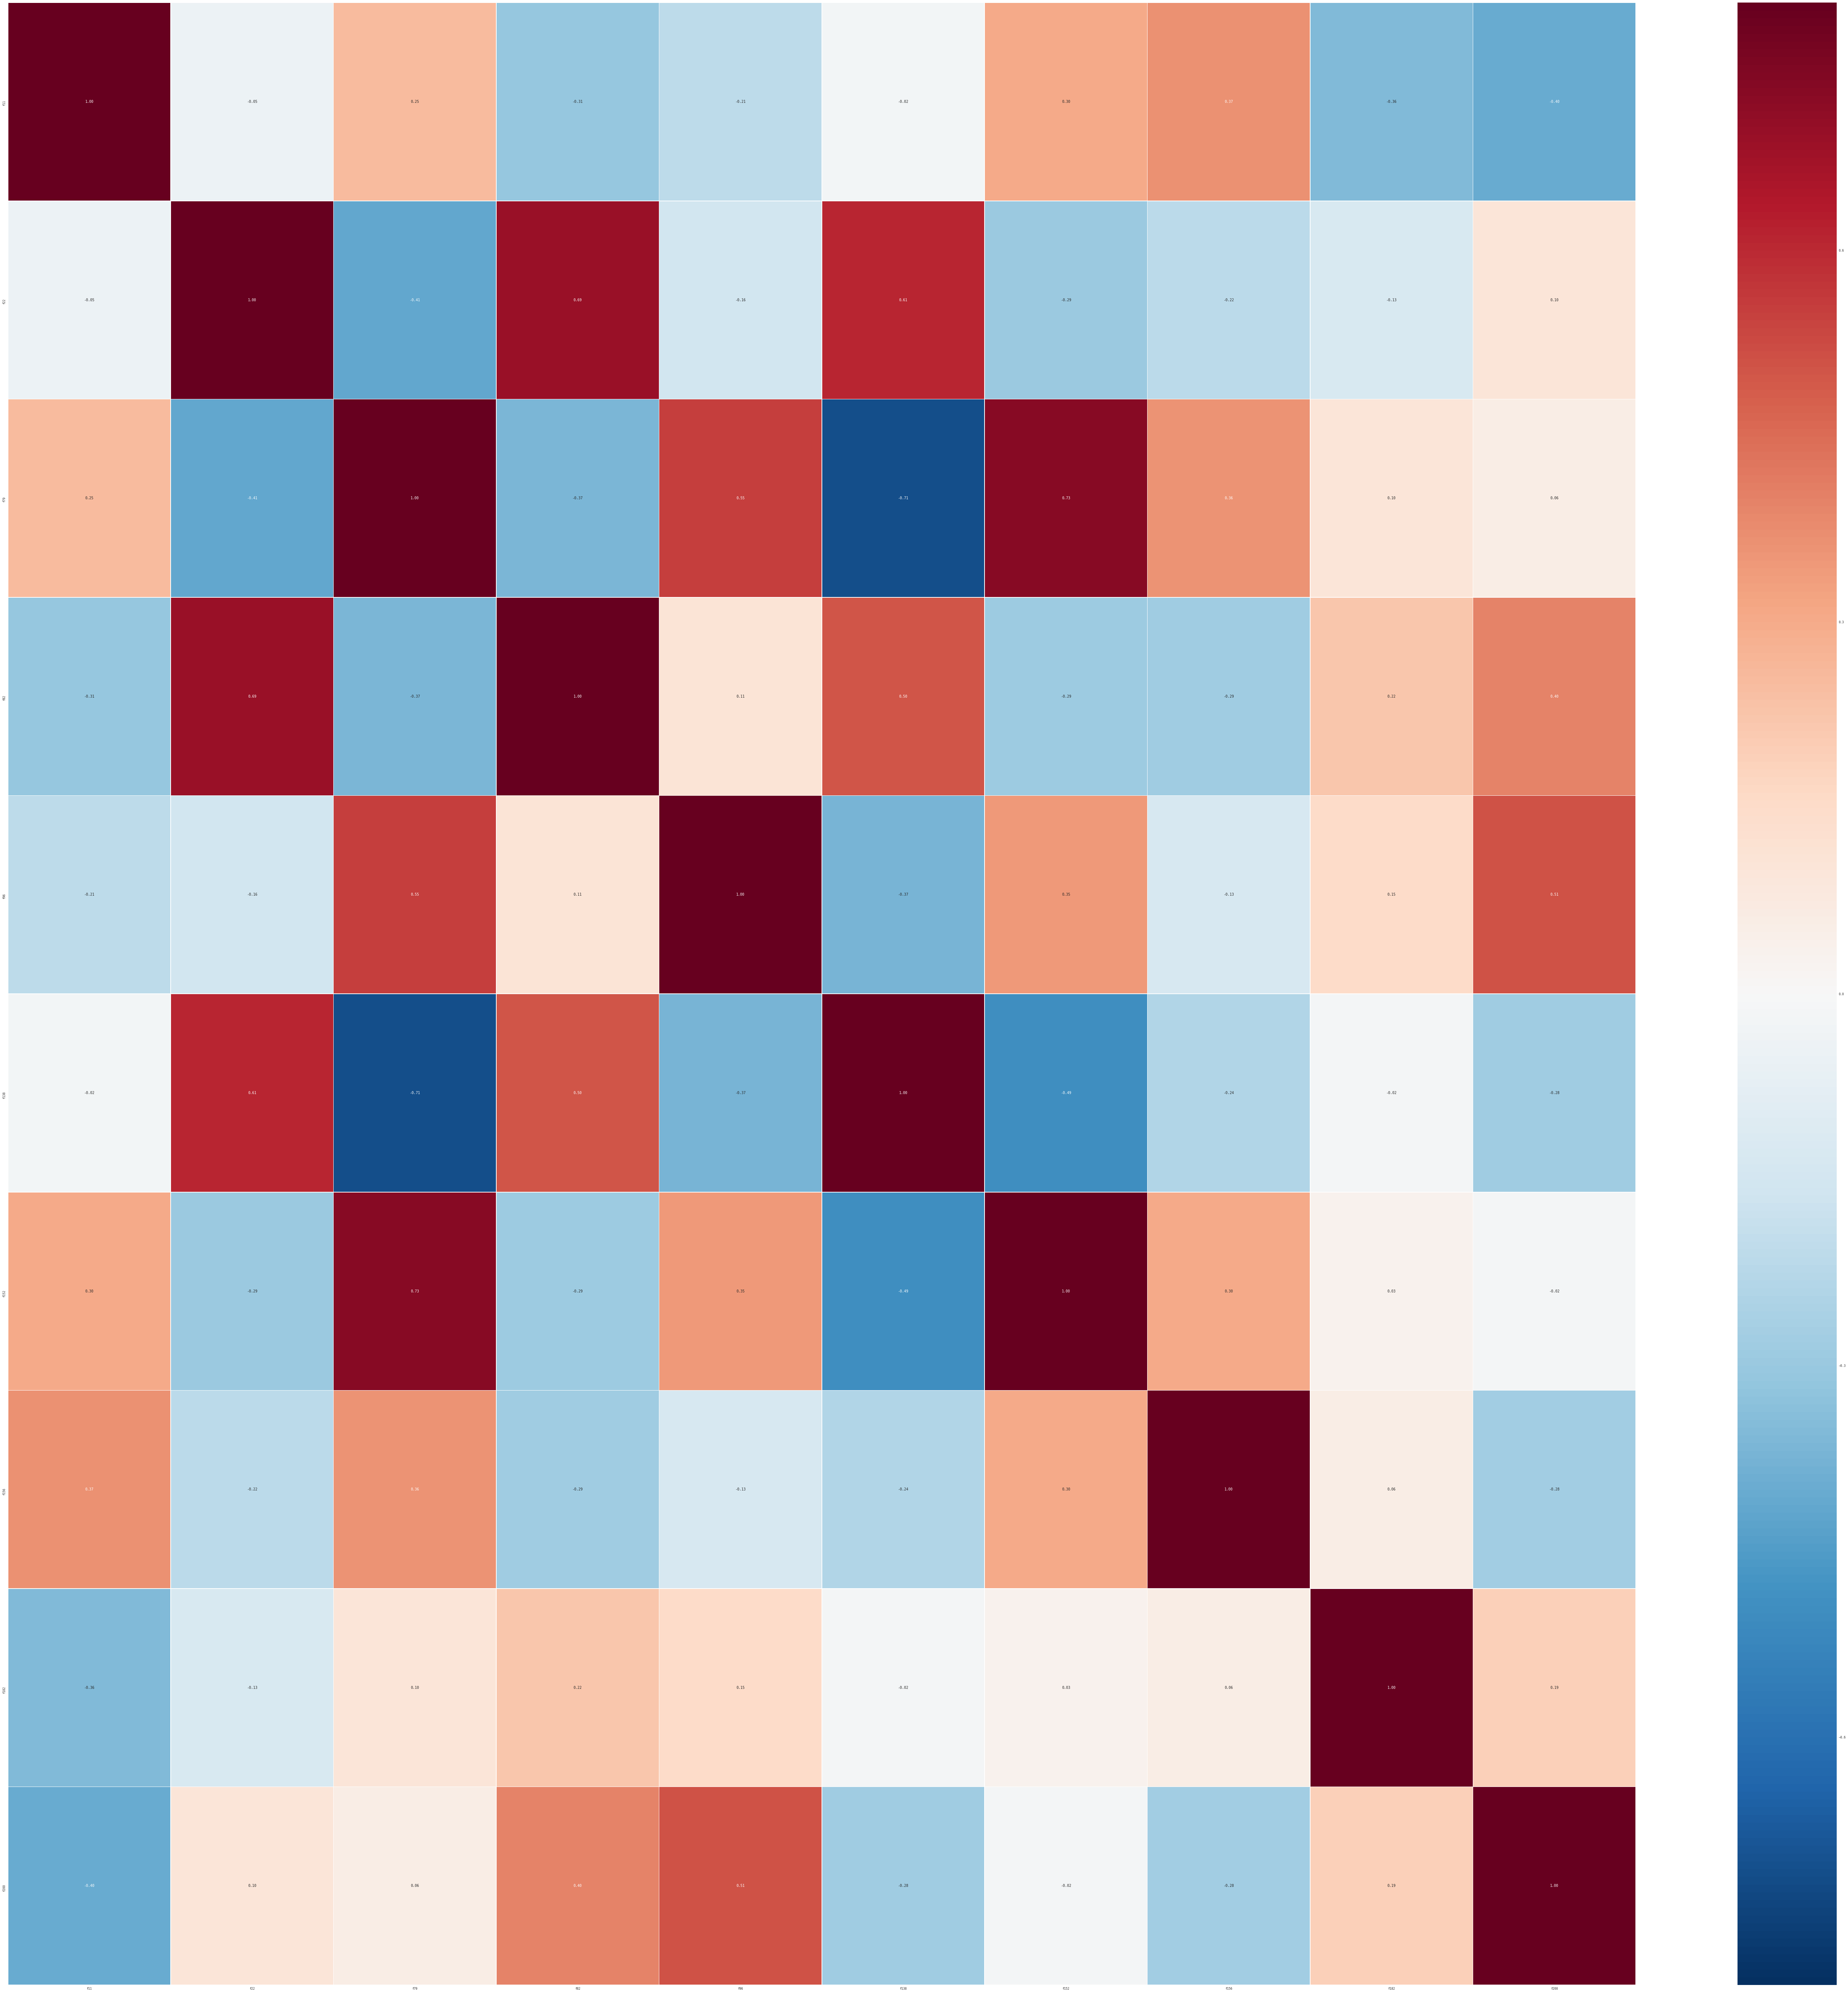

In [295]:
sns.set(context="paper", font="monospace")
plt.figure(figsize=(100, 100))
sns_heatmap = sns.heatmap(X.corr(), vmax=.8,annot=True, ffmt=".2f", linewidths=.5)
plt.show()

Строим модель 

In [378]:
rf=RandomForestClassifier(max_features='auto',n_estimators=300,max_depth=100,random_state=42)
print (np.mean(cross_val_score(rf, X, y, cv=5)))

0.614507490978


In [373]:
print(list(X.columns))
X.shape

['f11', 'f22', 'f82', 'f96', 'f138', 'f156', 'f182', 'f200']


(3489, 8)

# Отбор на основе Корреляции #2

In [6]:
import scipy.stats as stats

In [114]:
X_wocorr=X

In [115]:
def get_col(X,threshold):
    for i in X.columns:
        for j in X.columns:
            if i==j: continue
            corr,pvalue= stats.pearsonr(X[i],X[j])
            if abs(corr)>=threshold:
                if midf.loc[i,'mi']>midf.loc[j,'mi']:
                    return j
                else: return i
    return None

In [116]:
corr_threshold=0.70
col_to_del=get_col(X_wocorr,corr_threshold)
while not (col_to_del==None):
    X_wocorr.drop(labels=col_to_del,axis=1,inplace=True)
    col_to_del=get_col(X_wocorr,corr_threshold)
X_wocorr.shape

KeyboardInterrupt: 

In [ ]:
X_wocorr.columns

In [ ]:
rf=RandomForestClassifier(max_features='auto',n_estimators=300,max_depth=100,random_state=42)
print (np.mean(cross_val_score(rf, X_wocorr, y, cv=5)))

In [99]:
midf.loc[['f11', 'f22', 'f82', 'f96', 'f138', 'f152', 'f156', 'f180', 'f182', 'f187', 'f200']]

,mi
f11,0.058147
f22,0.075478
f82,0.089469
f96,0.070460
f138,0.150135
f152,0.034191
f156,0.069878
f180,0.043542
f182,0.040058
f187,0.032739


# Проверка на нормальность

In [33]:
stats.shapiro(stats.boxcox(X['f0']))

ValueError: Data must be positive.

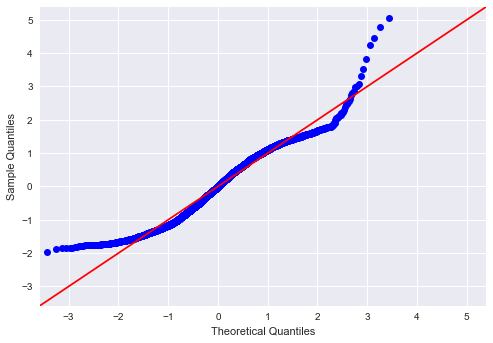

In [29]:
from statsmodels.graphics.gofplots import qqplot
qqplot(X['f3'], line='45', fit=True);
plt.show()

## лучший набор фич

In [ ]:
best_cols=['f11', 'f22', 'f82', 'f96', 'f138', 'f156', 'f182', 'f200']

In [177]:
f_classif

<function sklearn.feature_selection.univariate_selection.f_classif>

In [178]:
from sklearn.feature_selection import f_classif

In [210]:
f=f_classif(X,y)
fpd=pd.DataFrame(index=X.columns)
fpd.insert(loc=0,column='f',value=f[0])
fpd.insert(loc=0,column='p',value=f[1])
fpd.head()

,p,f
f0,3.321544e-186,245.802834
f1,4.077349e-07,8.861165
f2,2.055534e-07,9.226298
f3,1.396780e-04,5.713690
f4,2.081572e-01,1.471250


In [218]:
fpd.loc['f196']

p    0.167733
f    1.614449
Name: f196, dtype: float64

# Построим несколько моделей на оставшихся фичах

In [379]:
rf=RandomForestClassifier(max_features='auto',n_estimators=300,max_depth=100,random_state=42)
print (np.mean(cross_val_score(rf, X, y, cv=5)))

0.614507490978


In [380]:
def get_score(clf,X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    cv_score = cross_val_score(clf, X_train, y_train, cv=5).mean()
    print ("CVScore:",cv_score)
    clf.fit(X_train,y_train)
    print ("HoldOut:",clf.score(X_test,y_test))
xgbclf=xgb.XGBClassifier(max_depth=9,colsample_bytree=0.8,min_child_weight=2.0,n_estimators=326,gamma=0.8,subsample=0.5,seed=42)
get_score(xgbclf,X,y)
#CVScore: 0.529079318252
# HoldOut: 0.549188156638

CVScore: 0.572066181112
HoldOut: 0.574976122254


In [201]:
X.shape

(3489, 91)

#  recursive feature elimination.

In [389]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold

In [392]:
X=pd.read_csv('x_train.csv',delimiter=";",header=None,names=['f'+str(i) for i in range (223)])
y=pd.read_csv('y_train.csv',names=['class'])
y=y['class']
X_test=pd.read_csv('x_test.csv',delimiter=";",header=None,names=['f'+str(i) for i in range (223)])

Optimal number of features : 220


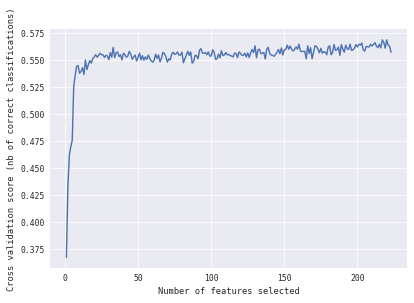

In [404]:
est = RandomForestClassifier(max_features='auto',n_estimators=300,max_depth=100,random_state=42)
rfecv = RFECV(estimator=est, step=1, cv=StratifiedKFold(5),scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [405]:
best_ftr_rfe=list(X.columns[rfecv.support_])

In [406]:
rf=RandomForestClassifier(max_features='auto',n_estimators=300,max_depth=100,random_state=42)
print (np.mean(cross_val_score(rf, X[best_ftr_rfe], y, cv=5)))

0.568923935405


In [407]:
xgbclf=xgb.XGBClassifier(max_depth=9,colsample_bytree=0.8,min_child_weight=2.0,n_estimators=326,gamma=0.8,subsample=0.5,seed=42)
get_score(xgbclf,X[best_ftr_rfe],y)

CVScore: 0.533975594372
HoldOut: 0.562559694365
